Client (or Local) notebook used to measure the throughput and latency of the retina and standard pipeline.

This notebook samples the retinal vectors and frames and sends them to the benchmark_server notebook 

In [ ]:
#!pip install import-ipynb
import import_ipynb
from RetinaUtils import Retina

import numpy as np
import cv2
import zmq
import time
import pickle
from matplotlib import pyplot as plt
import zlib

In [ ]:
### Load Piotr's Retina
R = Retina(gpu=False)
R.loadLoc('../retina_data/retinas/ret50k_loc.pkl')
R.loadCoeff('../retina_data/retinas/ret50k_coeff.pkl')
fixation = (1080/2,1920/2)
shape = (1080, 1920)
R.prepare(shape, fixation)

In [ ]:
#Pre compress the frames and retinal vectors for a fair comparison
def pre_sample(path, retina=False, n=100):
    #Open video or webcam
    vidcap = cv2.VideoCapture(path)
    success, message = vidcap.read()
    count = 1
    #Store messages
    messages = []
    while success:
        if count%(n+1)==0:
            break
        #Sample the images to get the retinal vectors
        if retina:
            message = R.sample(message, fixation).astype('uint8')
        #Compress the messages using zlib
        data = pickle.dumps(message, protocol=-1)
        data = zlib.compress(data, 6)
        messages.append(data)
        
        #Move onto next image
        success, message = vidcap.read()
        count += 1
    vidcap.release()
    return messages
#Set path to zero if you don't have a video. This will simply open the webcam
path = 'Jellyfish.mp4'
#path = 0

#Amount of messages we want to sent
num_messages = 10
#Compressed retinal vectors used for the retina pipeline
retinal_vectors = pre_sample(path, retina=True, n=num_messages)
#Compressed frames used for the standard pipeline
compressed_frames = pre_sample(path, retina=False, n=num_messages)

In [ ]:
#Measure the latency. Takes messages to send and number of runs
def measure_latency(messages, runs):
    #Connect to Server
    context = zmq.Context()
    socket = context.socket(zmq.PUSH)
    socket.connect("tcp://localhost:5555")
    
    #Save start times
    start_times=[]
    for i in range(0,runs):
        #In case there are fewer messages than runs, loop over the messages
        ind = i%len(messages)
        message = messages[ind]
        #Start timer and send message
        start_times.append(time.time())
        socket.send(message)
    #Send all the starting times, which will be used to calculate the latency
    socket.send_string(str(start_times))

#Measure the throughput.
def measure_throughput(messages, runs, n):
    #Connect to the Server
    context = zmq.Context()
    socket = context.socket(zmq.PUSH)
    socket.connect("tcp://localhost:5555")
    
    #Tell server how many messages will be sent per run
    socket.send_string(str(n))
    for i in range(0, runs):
        #Send messages
        for message in messages[:n]:
            socket.send(message)

In [ ]:
#Number of runs
runs = 100

## Throughput

In [ ]:
### Measure the retinal pipeline throughput over 100 runs
measure_throughput(retinal_vectors, runs, num_messages)

In [ ]:
### Measure the standard pipeline throughput over 100 runs
measure_throughput(compressed_frames, runs, num_messages)

## Latency

In [ ]:
### Measure latency for the retina pipeline
measure_latency(retinal_vectors, runs)

In [ ]:
### Measure latency for the standard pipeline
measure_latency(compressed_frames, runs)

In [ ]:
# Arbitrary 64 byte message
message = pickle.dumps('abcdefghigklmnop', protocol=-1)
messages = [message]*10000
# Measure latency for arbitrary messages
measure_latency(messages, 10000)

In [ ]:
#Show that arbitrary message is indeed 64 bytes
import sys
sys.getsizeof(message)

64

### Message size distribution

Retinal - Average: 0.128478, Min: 0.119339, Max: 0.136347
Frame - Average: 2.343286, Min: 1.641801, Max: 2.988065


Text(0, 0.5, 'Message size (Megabytes)')

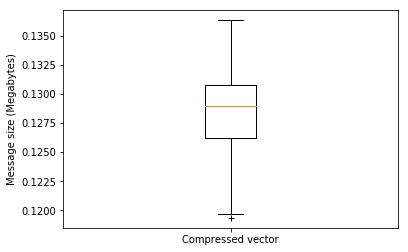

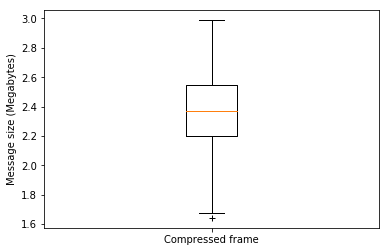

In [ ]:
### Show the message size distribution for the compressed retinal vectors vs the compressed frames

#Turn to Megabytes
retinal_sizes = [len(x)/1e6 for x in retinal_vectors]
frame_sizes = [len(x)/1e6 for x in compressed_frames]
print('Retinal - Average: %f, Min: %f, Max: %f'%(np.mean(retinal_sizes),min(retinal_sizes),max(retinal_sizes)))
print('Frame - Average: %f, Min: %f, Max: %f'%(np.mean(frame_sizes),min(frame_sizes),max(frame_sizes)))

#Plot
plt.figure()
plt.boxplot(retinal_sizes, sym='+')
plt.xticks([1],['Compressed vector'])
plt.ylabel('Message size (Megabytes)')
#plt.savefig('retinal_size.eps')

plt.figure()
plt.boxplot(frame_sizes, sym='+')
plt.xticks([1],['Compressed frame'])
plt.ylabel('Message size (Megabytes)')
#plt.savefig('frame_size.eps')